### Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix




### Data Preprocessing( Setting Up Image Data Generators)

In [2]:


# Constants
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Data
train_generator = train_datagen.flow_from_directory(
    'F:/TEJA/DL/PROJ_7/data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation Data
validation_generator = val_datagen.flow_from_directory(
    'F:/TEJA/DL/PROJ_7/data/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Data
test_generator = test_datagen.flow_from_directory(
    'F:/TEJA/DL/PROJ_7/data/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Number of Classes
num_classes = len(train_generator.class_indices)


Found 15000 images belonging to 6 classes.
Found 252 images belonging to 6 classes.
Found 504 images belonging to 6 classes.


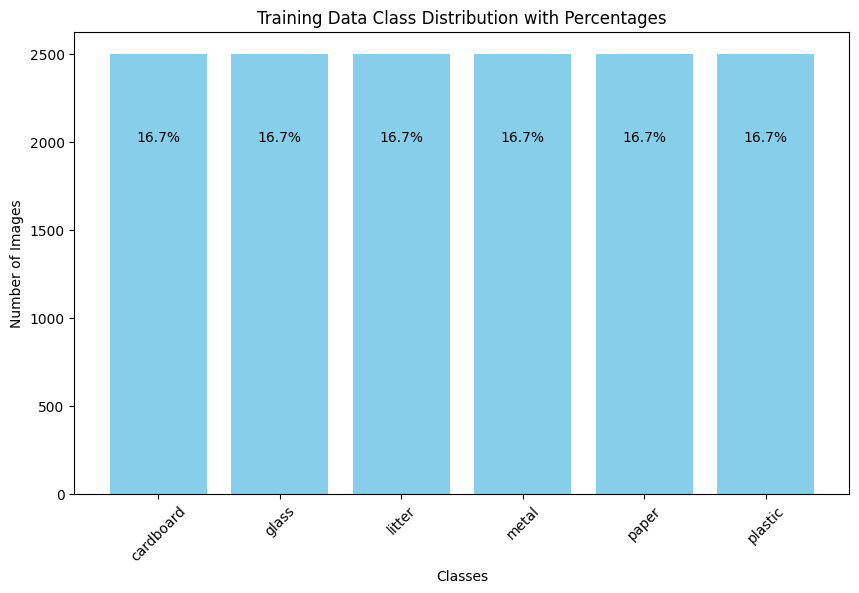

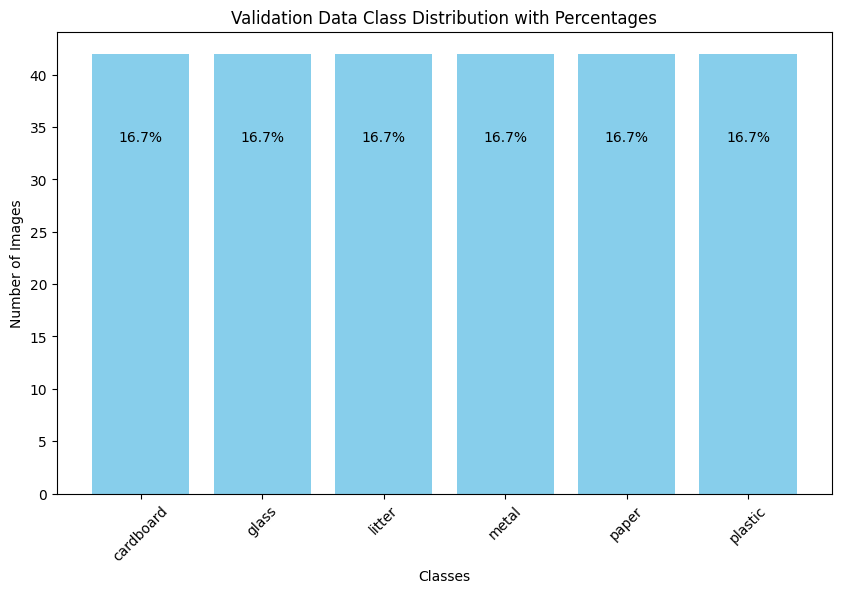

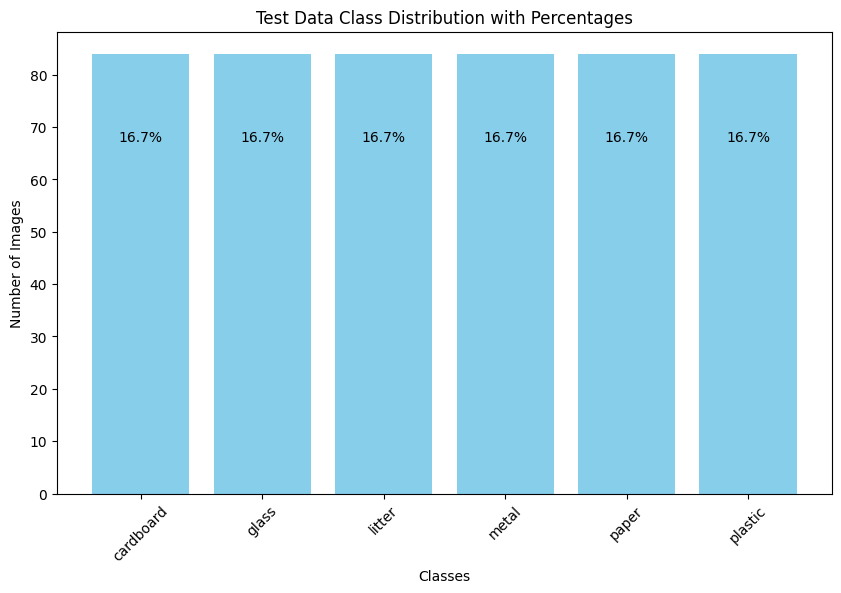

In [3]:
def plot_class_distribution_with_percentage(generator, title):
    labels, counts = zip(*generator.class_indices.items())
    sample_counts = [len(generator.filepaths[i::len(generator.class_indices)]) for i in range(len(generator.class_indices))]
    total_samples = sum(sample_counts)
    percentages = [(count / total_samples) * 100 for count in sample_counts]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, sample_counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    
    # Annotate with percentages
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - bar.get_height() * 0.2,
                 f"{pct:.1f}%", ha='center', color='black', fontsize=10)
    plt.show()

# Plot class distribution with percentages
plot_class_distribution_with_percentage(train_generator, "Training Data Class Distribution with Percentages")
plot_class_distribution_with_percentage(validation_generator, "Validation Data Class Distribution with Percentages")
plot_class_distribution_with_percentage(test_generator, "Test Data Class Distribution with Percentages")


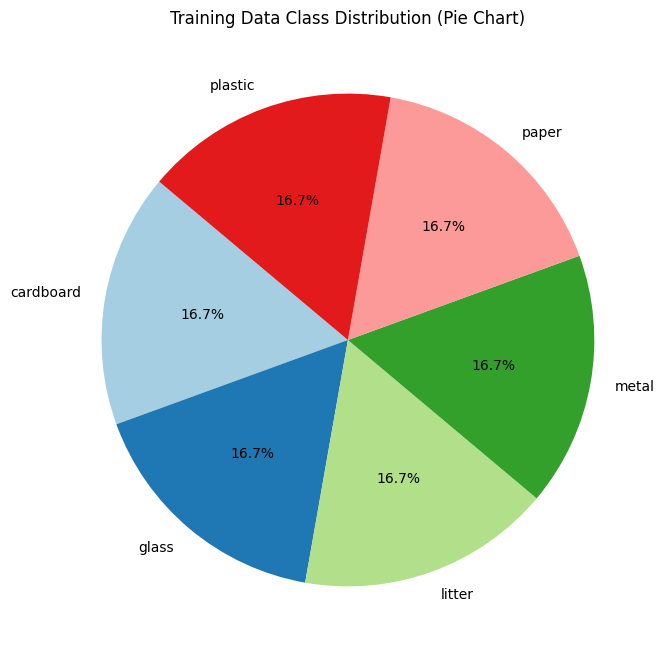

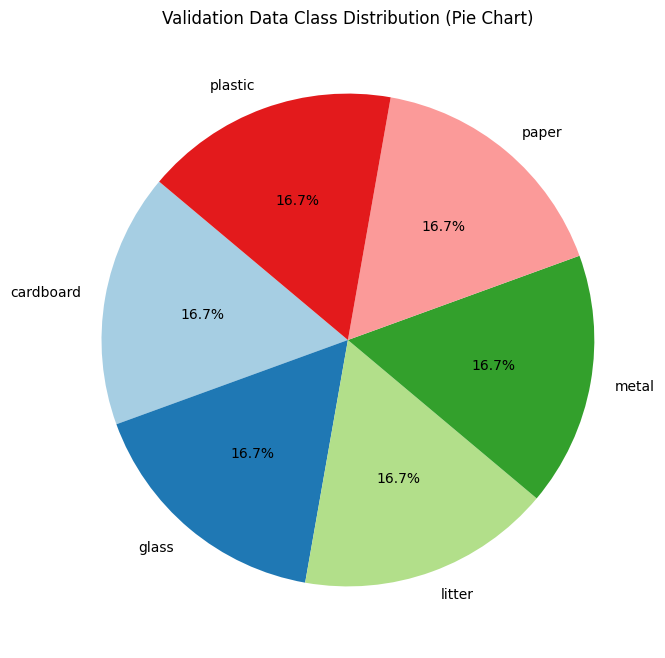

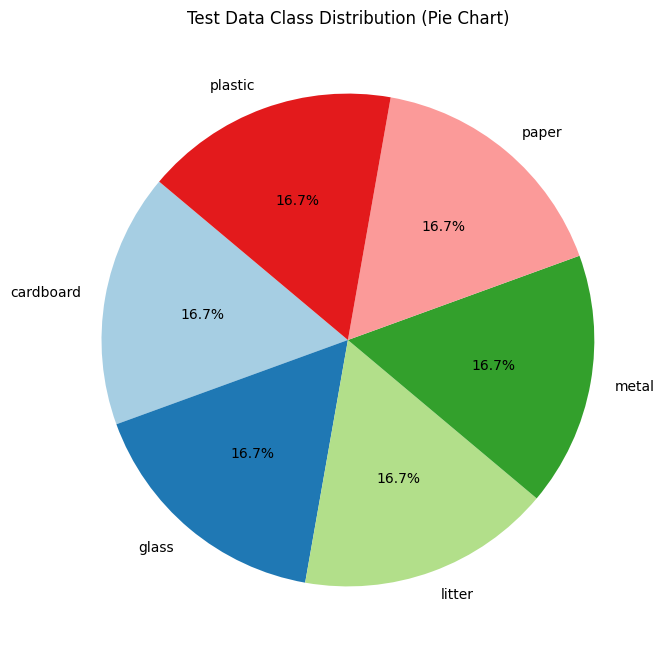

In [4]:
def plot_class_distribution_pie(generator, title):
    labels, counts = zip(*generator.class_indices.items())
    sample_counts = [len(generator.filepaths[i::len(generator.class_indices)]) for i in range(len(generator.class_indices))]
    
    plt.figure(figsize=(8, 8))
    plt.pie(sample_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.show()

# Plot class distribution as pie charts
plot_class_distribution_pie(train_generator, "Training Data Class Distribution (Pie Chart)")
plot_class_distribution_pie(validation_generator, "Validation Data Class Distribution (Pie Chart)")
plot_class_distribution_pie(test_generator, "Test Data Class Distribution (Pie Chart)")


### Building and Compiling the NASNet Model

In [ ]:

# Base Model (NASNetLarge)
base_model_nasnet = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze NASNetLarge Layers
for layer in base_model_nasnet.layers:
    layer.trainable = False

# Add Custom Layers for Classification
x = base_model_nasnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final Model
nasnet_model = Model(inputs=base_model_nasnet.input, outputs=predictions)

# Compile the Model
nasnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Summary
nasnet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 96)         2592      ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 96)         0         ['stem_bn1[0][0]']        

### Training and Validation

In [6]:

# Train the Model
history_nasnet = nasnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the Model
val_loss, val_acc = nasnet_model.evaluate(validation_generator)
print(f"NASNetLarge Validation Accuracy: {val_acc}")

469/469 [==============================] - 3672s 8s/step - loss: 0.4675 - accuracy: 0.8331 - val_loss: 0.2578 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 3821s 8s/step - loss: 0.2216 - accuracy: 0.9169 - val_loss: 0.1116 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 3970s 8s/step - loss: 0.1591 - accuracy: 0.9377 - val_loss: 0.0461 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 4559s 10s/step - loss: 0.1330 - accuracy: 0.9457 - val_loss: 0.1002 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 5028s 11s/step - loss: 0.1089 - accuracy: 0.9494 - val_loss: 0.0741 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9535 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
469/469 [==============================] - 5912s 13

In [7]:
print(f"NASNetLarge Validation Accuracy: {val_acc}")

NASNetLarge Validation Accuracy: 0.9960317611694336


### Visualizing Model Accuracy and Loss

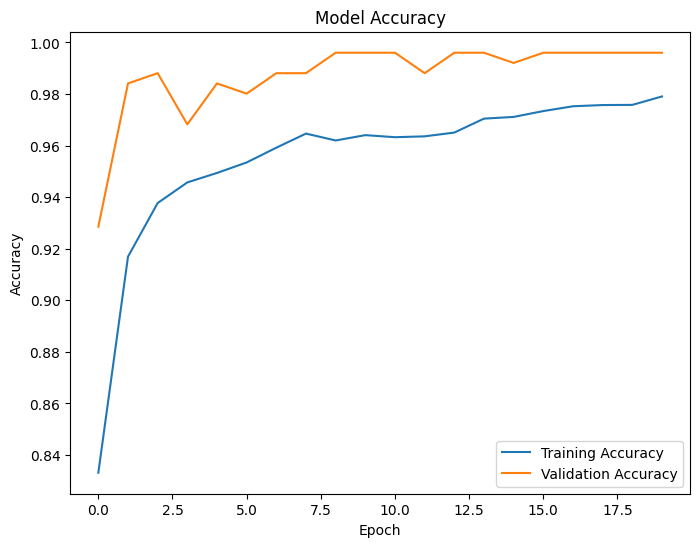

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history_nasnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_nasnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()




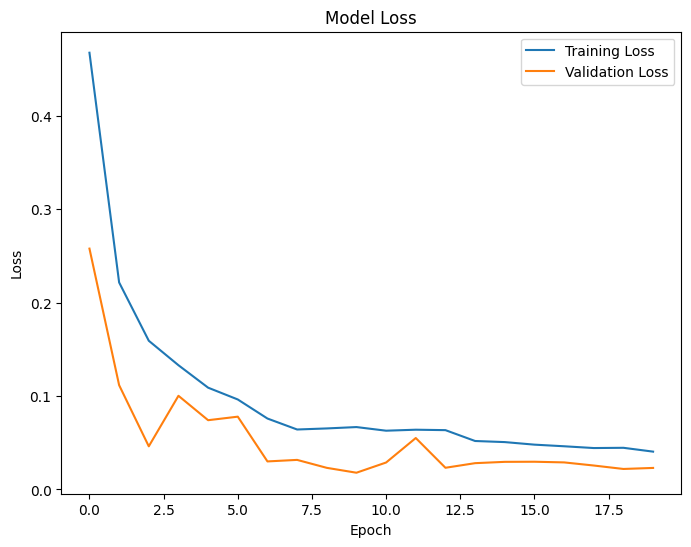

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history_nasnet.history['loss'], label='Training Loss')
plt.plot(history_nasnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

### Confusion Matrix

1/1 [==============================] - 8s 8s/step


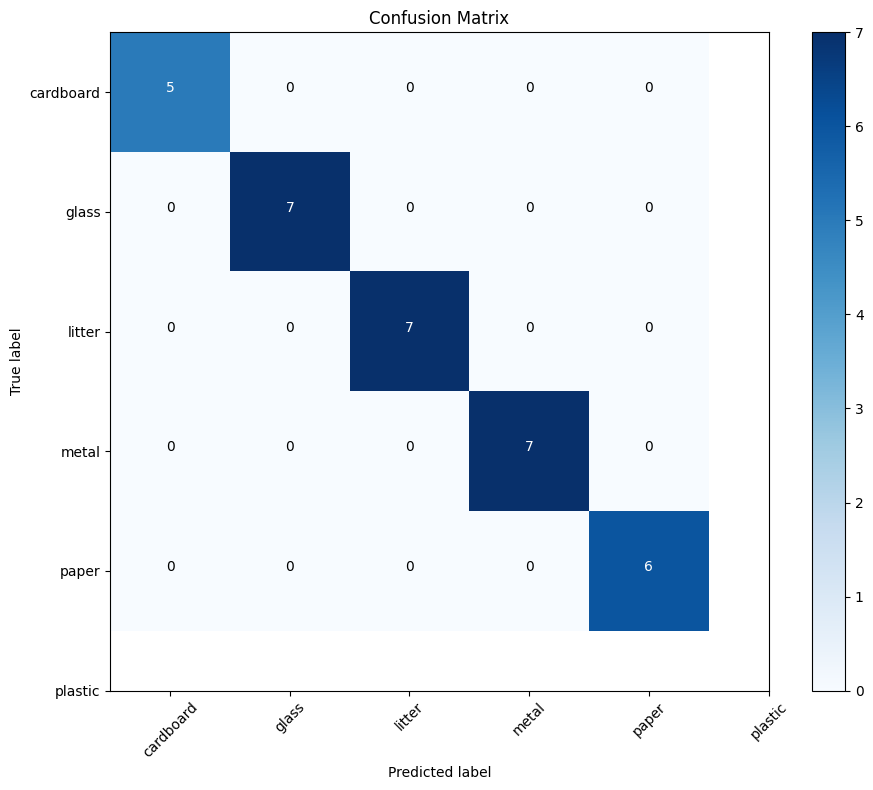

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Labeling the matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Get true labels and predictions for confusion matrix
val_images, val_labels = next(validation_generator)
val_predictions = nasnet_model.predict(val_images)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)


plot_confusion_matrix(val_true_classes, val_pred_classes, classes=train_generator.class_indices.keys())


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

y_pred = nasnet_model.predict(validation_generator, verbose=1)

y_true = validation_generator.classes  # true labels
y_pred_binary = np.argmax(y_pred, axis=1)  # predicted labels


print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary))




8/8 [==============================] - 61s 7s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.17      0.17        40
           1       0.18      0.18      0.18        50
           2       0.08      0.07      0.07        14
           3       0.15      0.15      0.15        41
           4       0.27      0.27      0.27        59
           5       0.10      0.10      0.10        48

    accuracy                           0.17       252
   macro avg       0.16      0.16      0.16       252
weighted avg       0.17      0.17      0.17       252



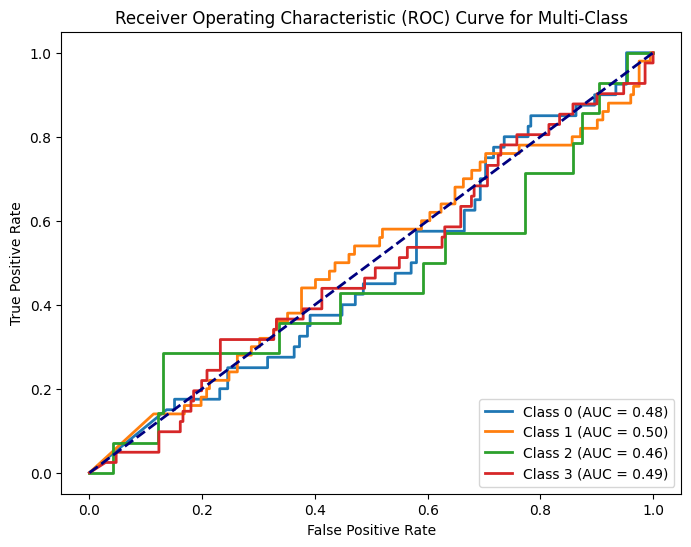

In [20]:
from sklearn.metrics import roc_auc_score

# One-hot encode the true labels (if needed)
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3])  # Update the class labels according to your classes
n_classes = y_true_one_hot.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()


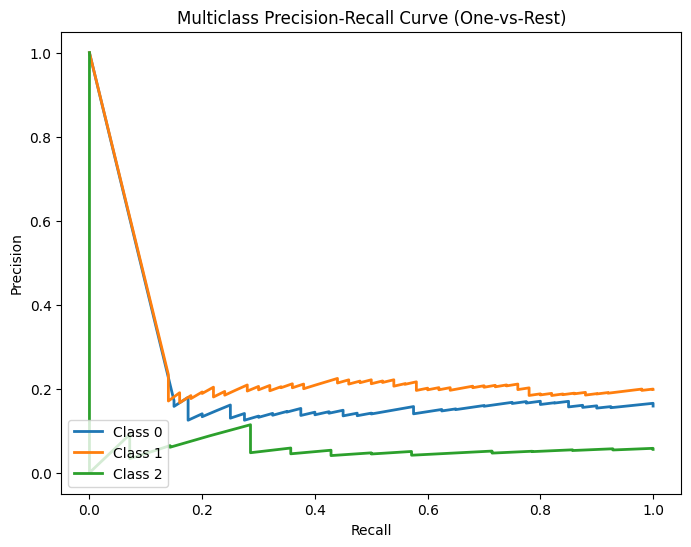

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming y_true is the true labels and y_pred is the predicted probabilities
# For multiclass, binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Replace with your class labels

# Loop over each class and compute precision-recall curve
plt.figure(figsize=(8, 6))
for i in range(y_true_bin.shape[1]):  # Iterate over each class
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall_vals, precision_vals, lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='lower left')
plt.show()


### Testing with Random Images

1/1 [==============================] - 8s 8s/step


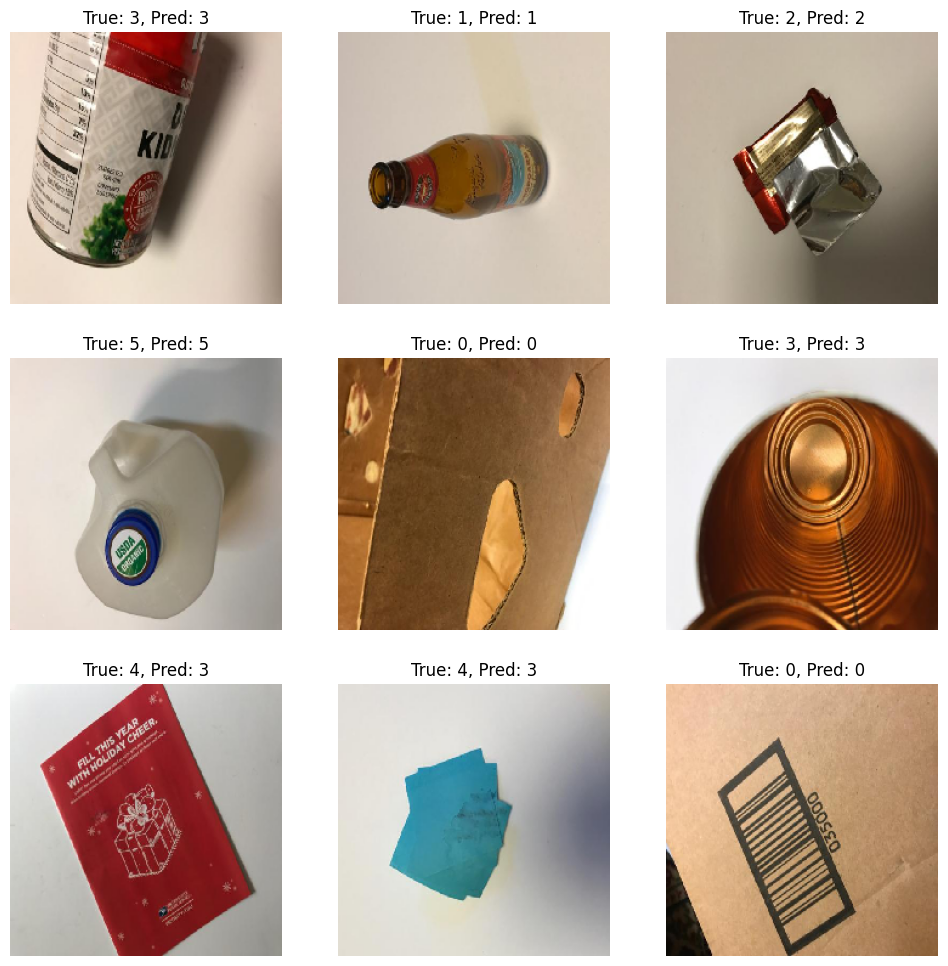

In [22]:
def plot_sample_predictions(generator, model, num_images=9):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
        plt.axis('off')
    plt.show()

plot_sample_predictions(test_generator, nasnet_model)


In [15]:
nasnet_model.save('Model2.h5')

C:\Users\Main Python2\anaconda3\envs\3.9\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
